### 目标
在本作业中，您将练习修剪经典的神经网络模型以减少模型大小和延迟。此作业的目标如下：

* 了解修剪的基本概念
* 实施和应用细粒度修剪
* 实施和应用通道剪枝
* 从修剪中获得对性能改进（例如加速）的基本了解
* 了解这些修剪方法之间的差异和权衡


### 内容
本实验室有两个主要部分：细粒度修剪和通道修剪。总共有9个问题：
* 对于细粒度修剪，有5个问题（问题1-5）。
* 对于通道修剪，有3个问题（问题6-8）。
* 问题9比较了细粒度修剪和通道修剪。

### 设置
首先，安装所需的包并下载数据集和预训练模型。这里我们使用CIFAR10数据集和VGG网络，这与我们在Lab 0教程中使用的相同。

In [1]:
# print('Installing torchprofile...')
# !pip install torchprofile 1>/dev/null
# print('All required packages have been successfully installed!')

In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

#### 下载函数
这个 download_url 函数的主要功能是从指定 URL 下载文件并将其保存到本地指定的目录。它支持文件覆盖、目录创建，并在下载失败时提供错误信息。需要注意的是，禁用 SSL 验证可能会带来安全风险，使用时应根据具体情况谨慎处理。

In [3]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

#### VGG
* 这个 VGG 模型类实现了一个标准的 VGG 结构，包括多个卷积层、批量归一化、ReLU 激活和最大池化层。它的设计具有模块化和灵活性，可以轻松调整网络架构。
* 前向传播过程中，模型能够从输入图像生成类别预测。

In [4]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

#### 训练函数
这个 train 函数提供了一种标准的方法来训练 PyTorch 模型，涵盖了前向推理、损失计算、梯度更新和学习率调整等步骤。通过可选的回调参数，用户可以在训练过程中灵活地添加自定义逻辑。

In [5]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

#### 评估函数
evaluate 函数通过逐批次地将输入数据传入模型，计算模型的预测结果，并与实际标签进行比较，从而评估模型的性能。它返回模型在给定数据集上的准确率，并提供了灵活的参数来控制输出的详细程度。这个函数适合在模型训练后进行验证，以了解模型的泛化能力。

In [6]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

#### 辅助函数
辅助函数（触发器、模型大小计算等）
* 这些函数提供了对模型性能的深入分析，帮助开发者理解模型的复杂性和稀疏性。这些信息对于优化模型、减小模型大小以及在实际应用中提升推理速度都非常重要。

In [7]:
# 获取模型的MACs
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

# 计算张量的稀疏性
def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

# 计算模型的稀疏性
def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

# 计算模型的参数数量
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

# 计算模型大小
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

# 常量定义
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

#### 杂项函数
定义用于验证的杂项函数。
* 这段代码定义了一个用于测试细粒度剪枝（fine-grained pruning）功能的函数
* 这个函数通过可视化、稀疏性计算和结果验证来测试细粒度剪枝的有效性。这种测试方法有助于评估剪枝技术的效果，并确保模型在实现稀疏化的同时保持准确性。

In [8]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

#### 下载数据
加载预训练模型和CIFAR-10数据集。
* 这段代码用于加载一个预训练的 VGG 模型权重，并将其恢复到指定的模型实例中。以下是代码的详细说明：

In [9]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

C:\Users\17363\AppData\Local\Temp\ipykernel_58852\3977767905.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(download_url(checkpoint_url), map_lo

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [10]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### 密集型模型评估
让我们首先评估密集模型的准确性和模型大小
* 神经网络在许多应用中变得无处不在。在这里，我们加载了一个预训练的VGG模型，用于对CIFAR10数据集中的图像进行分类。我们先来评估一下这个模型的精度和模型大小。

In [11]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


虽然大型神经网络非常强大，但它们的大小消耗了大量的存储、内存带宽和计算资源。 正如我们从上面的结果中看到的，一个像分类一样简单的任务模型32×3210类的图像可以大到35 MiB。 对于嵌入式移动应用程序，这些资源需求变得令人望而却步。

因此，利用神经网络剪枝来促进包含DNN的移动应用程序的存储和传输。

修剪的目标是在保持准确性的同时减小模型大小。

### 权重值分布
让我们看看权重值的分布
* 在我们开始修剪之前，让我们看看密集模型中权重值的分布。
* 这段代码定义了一个函数 plot_weight_distribution，用于可视化给定模型的权重分布。它会生成一个包含多个子图的直方图，显示每个可学习参数的权重分布情况。
* 调用 plot_weight_distribution(model) 会生成一个 3x3 的子图矩阵，显示模型各个层的权重分布情况。权重分布的可视化可以帮助你理解模型中权重的稀疏性以及训练过程中的变化。这对于优化模型和调试都是非常有用的。
* 如果想只看非零权重的分布，可以使用 plot_weight_distribution(model, count_nonzero_only=True)。

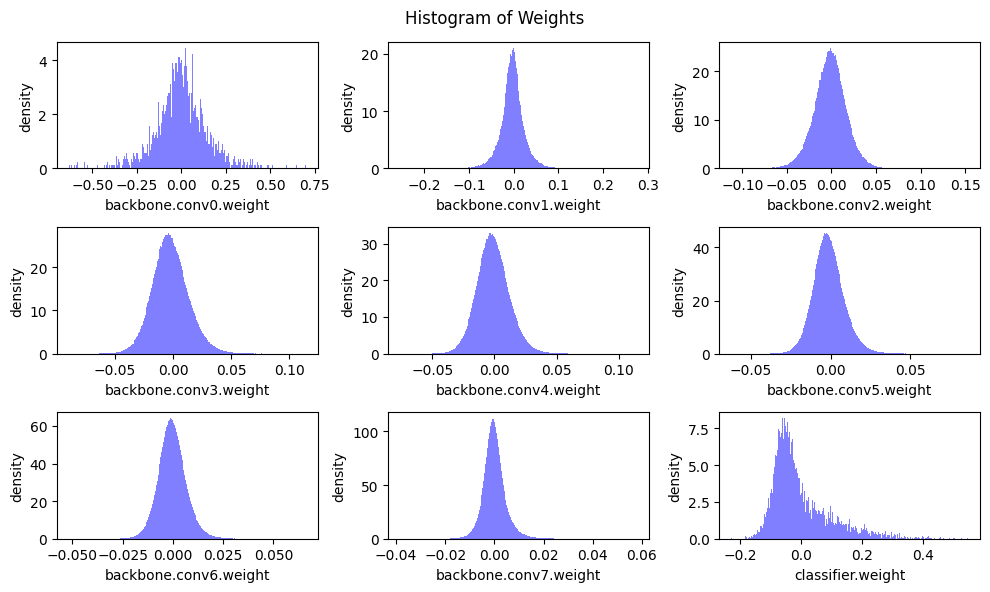

In [12]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

`backbone.conv0.weight` 和 `classifier.weight` 通常指的是深度学习模型中的两个关键部分的权重：

`backbone.conv0.weight:`

* 这里的 "backbone" 通常指卷积神经网络（CNN）模型的主体部分（即特征提取器）。
* “conv0” 表示模型中的第一个卷积层。它是网络中最接近输入图像的层，负责提取图像的低级特征，如边缘、纹理等。
* weight 是指卷积核（filters）的权重矩阵，它会随着训练更新，用于识别图像中的特征。

`backbone.conv0.weight` 代表了模型第一层卷积层的权重，它通常对图像的预处理非常关键，因为它负责将原始输入转换为可以被后续层进一步处理的特征表示。

`classifier.weight:`

* “classifier” 通常指的是模型的分类器部分，尤其在图像分类任务中，这一部分是负责对提取的特征进行最终的分类。
* 在许多模型（如 ResNet、VGG 等）中，分类器通常是由一个或多个全连接层（Fully Connected Layers, FC）组成。
* weight 代表了这些全连接层的权重矩阵，用于将前一层提取的特征映射到不同类别的输出。

`classifier.weight `代表模型最后的分类层的权重，用于将提取到的特征最终转化为分类的预测值。

#### 问题1（10分）
请使用上述权重直方图中的信息回答以下问题。
##### 问题1.1（5分）
不同层的重量分布有什么共同特征？

答：
* 大多数分布为钟形曲线：除了最左上角的 `backbone.conv0.weight` 和最右下角的 `classifier.weight`，其他层的权重分布几乎呈现正态分布（钟形），表明大多数权重集中在零附近，权重较大的值非常少。
* 对称性：这些分布大多是对称的，以零为中心，左侧和右侧的权重分布相似。这意味着在这些层中，正负权重的大小和数量相对均匀。
* 零权重集中：在大多数层中，权重值接近于零的密度最高，表明这些网络的许多权重可能在训练中被压缩至接近零的值。
* 尾部较小：除了 `backbone.conv0.weight` 和 `classifier.weight` 外，大部分权重分布的尾部都相对较短，这意味着极端大或极端小的权重较少。
* 层间差异较小：除了 `backbone.conv0.weight` 和 `classifier.weight`，其他大部分卷积层的分布形状相似，表明这些卷积层在权重初始化或训练时可能遵循相似的策略。


##### 问题1.2（5分）
这些特性如何帮助修剪？

答：
这些权重分布的特性对模型的修剪有重要意义：
* 权重集中在零附近：当大部分权重接近零时，说明这些权重对最终的输出影响较小。因此，在修剪过程中，可以安全地将这些接近零的权重置为零，从而减少模型的复杂度，提升推理效率。
* 分布对称且尾部较短：分布的对称性和尾部的短小特征意味着极端权重较少，许多不重要的权重可以通过修剪删除，不会对模型性能造成较大影响。
* 不同层权重分布相似：由于多个层的权重分布都相似，可以针对相似的层使用统一的修剪策略，减少了为每个层设计不同修剪标准的复杂性。
* 过大的权重异常值可以忽略：部分层（如 classifier.weight 和 backbone.conv0.weight）的权重分布有较多的高权重值，这些值可能代表模型中的少数关键连接，但在其他层中权重集中于较小范围，因此可以针对不同层权衡修剪的程度。
* 这些特性使得基于权重大小的修剪方法（如剪掉小于某一阈值的权重）变得有效，从而在不显著影响模型性能的情况下，显著减少参数数量，优化计算和存储资源。

### 细粒度修剪
在本节中，我们将实现并执行细粒度修剪。
细粒度修剪去除重要性最低的突触。权重张量 W 细粒度修剪后会变得稀疏，可以用稀疏性:

$\text{sparsity}:=\#\text{Zeros}/\#W=1-\#\text{Nonzeros}/\#W$

哪里 #W 是元素的数量 W .

在实践中，考虑到目标稀疏性 s ，权重张量 W 与二进制掩码相乘 M 忽略去除的重量：

$\begin{aligned}
&v_{\mathrm{thr}}=\mathbf{kthvalue}(Importance,\#W\cdot s) \\
&M=Importance>v_{\mathrm{thr}} \\
&W=W\cdot M
\end{aligned}$

哪里 重要性 是具有相同形状的重要性张量 W ,  K值（X， k） 找到 k 张量的第-个最小值 $X,v_{\mathrm{thr}}$ 是阈值。

#### 基于幅度的修剪
对于细粒度修剪，一个广泛使用的重要性是权重值的大小，即，

$Importance=|W|$

这被称为基于幅度的修剪（请参阅学习权重和连接以提高效率 神经网络）https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fpdf%2F1506.02626.pdf 。
![alt text](../image/P1/剪枝.png)

##### 问题2（15分）
请完成以下基于幅度的细粒度剪枝功能。

提示：
* 第一步，我们计算修剪后的零点数（num_zeros）。注意，`num_zeros`应该是整数。您可以使用`round()`或`int()`将浮点数转换为整数。这里我们使用`round()`。
* 在步骤2中，我们计算权重张量的`importance`。Pytorch提供了`torch.abs()`，`torch.Tensor.abs()`，`torch.Tensor.abs_()` APIs。
* 在步骤3中，我们计算修剪`threshold`，以便所有重要性小于`threshold`的突触将被删除。Pytorch提供了`torch.kthvalue()`、`torch.Tensor.kthvalue()`、`torch.topk()API`。
* 在步骤4中，我们根据`mask`计算修剪`threshold`。1中的`mask`表示将保留突触，0中的`mask`表示将删除突触。`mask = importance > threshold`。Pytorch提供了`torch.gt()`API。

In [13]:
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    基于幅度的细粒度剪枝
    :param tensor: torch.(cuda.)Tensor, 卷积/全连接层的权重张量
    :param sparsity: float, 剪枝稀疏度
        稀疏度 = 零值数量 / 元素数量 = 1 - 非零值数量 / 元素数量
    :return:
        torch.(cuda.)Tensor, 零值掩码
    """
    # 处理边界情况和稀疏度设置，将稀疏度 sparsity 限制在 0.0 和 1.0 之间
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)
    
    # 张量的总数
    num_elements = tensor.numel()

    ##################### 实现步骤如下 #####################
    # Step 1: 计算需要的零值数目
    num_zeros = round(num_elements * sparsity)

    # Step 2: 计算权重的重要性 (取绝对值)  幅度剪枝方法假设绝对值越大的权重越重要。
    importance = tensor.abs()

    # Step 3: 计算剪枝阈值，使得比阈值小的权重会被剪枝。将权重的绝对值展开，获取最低阈值的标量
    if num_zeros > 0:
        threshold = importance.view(-1).kthvalue(num_zeros).values.item()
    else:
        threshold = 0

    # Step 4: 生成二进制掩码 (1 表示保留，0 表示剪枝)
    mask = torch.gt(importance, threshold).float()
    ##################### 代码结束 #######################

    # Step 5: 应用掩码来剪枝张量
    tensor.mul_(mask)

    return mask


让我们通过在虚拟张量上应用上面的函数来验证定义的细粒度剪枝的功能。

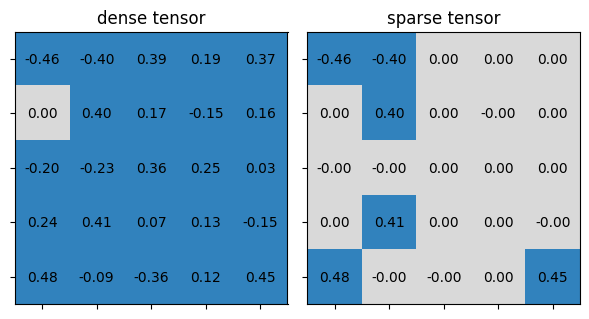

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [14]:
test_fine_grained_prune()

* 目标稀疏度：测试的目标稀疏度是 0.75，这意味着我们希望最终权重张量的 75% 元素被置零。
* 剪枝前稀疏度：剪枝前稀疏度为 0.04，说明只有 4% 的元素原本为零。
* 剪枝后稀疏度：剪枝后的稀疏度为0.76,非常接近目标稀疏度0.75,证明剪枝函数成功地按要求设置了大约75%的零值。
* 掩码稀疏度：剪枝掩码的稀疏度也为0.76，与剪枝后张量的稀疏度一致，说明掩码准确地标识了哪些元素应该被置零。

##### 问题3（5分）
最后一个单元格绘制剪枝前后的张量，非零用蓝色渲染，零用灰色渲染，请修改下面代码单元格中target_sparsity的值，使剪枝后的稀疏张量中只有10个非零。

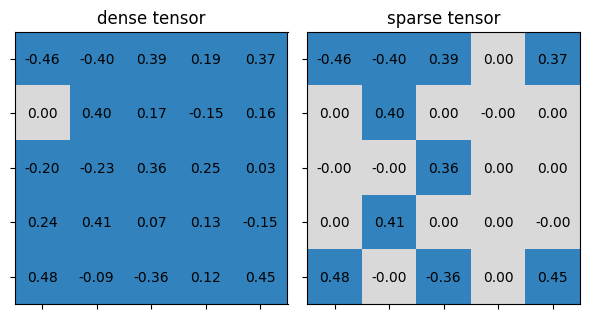

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [15]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 1 - 10 / 25  # 计算所需的稀疏度
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)


我们现在将细粒度的修剪函数包装到一个类中，用于修剪整个模型。在FineGrainedPruner类中，我们必须记录修剪掩码，以便在模型权重发生变化时应用掩码，以确保模型始终保持稀疏。

In [16]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    # 将剪枝掩码应用到模型的参数上，从而使非零位置的参数保留，零位置的参数被置零
    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    # 负责对模型中的各层生成剪枝掩码,仅对维度大于1（即卷积层和全连接层）的权重进行剪枝
    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

#### 灵敏度扫描
不同的层对模型性能的贡献不同。为每一层确定适当的稀疏度是一项挑战。一种广泛使用的方法是灵敏度扫描。

在灵敏度扫描过程中，每次我们只修剪一层以查看精度下降。通过扫描不同的稀疏度，我们可以绘制相应层的灵敏度曲线（即精度与稀疏度）。

这是灵敏度曲线的示例图。x轴是稀疏度或#参数丢弃的百分比（即稀疏度）。y轴是验证准确性。（这是学习高效神经网络的权重和连接中的图6 https://arxiv.org/pdf/1506.02626）
![alt text](../image/P1/灵敏度曲线.png)

下面的代码单元定义了灵敏度扫描函数，该函数返回扫描的稀疏度，以及要修剪的每个权重的精度列表。

In [17]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

请运行以下单元格来绘制灵敏度曲线。大约需要2分钟才能完成。

In [18]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.42%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.64%, 91.88%, 89.90%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.82%, 92.97%, 92.67%, 92.52%]

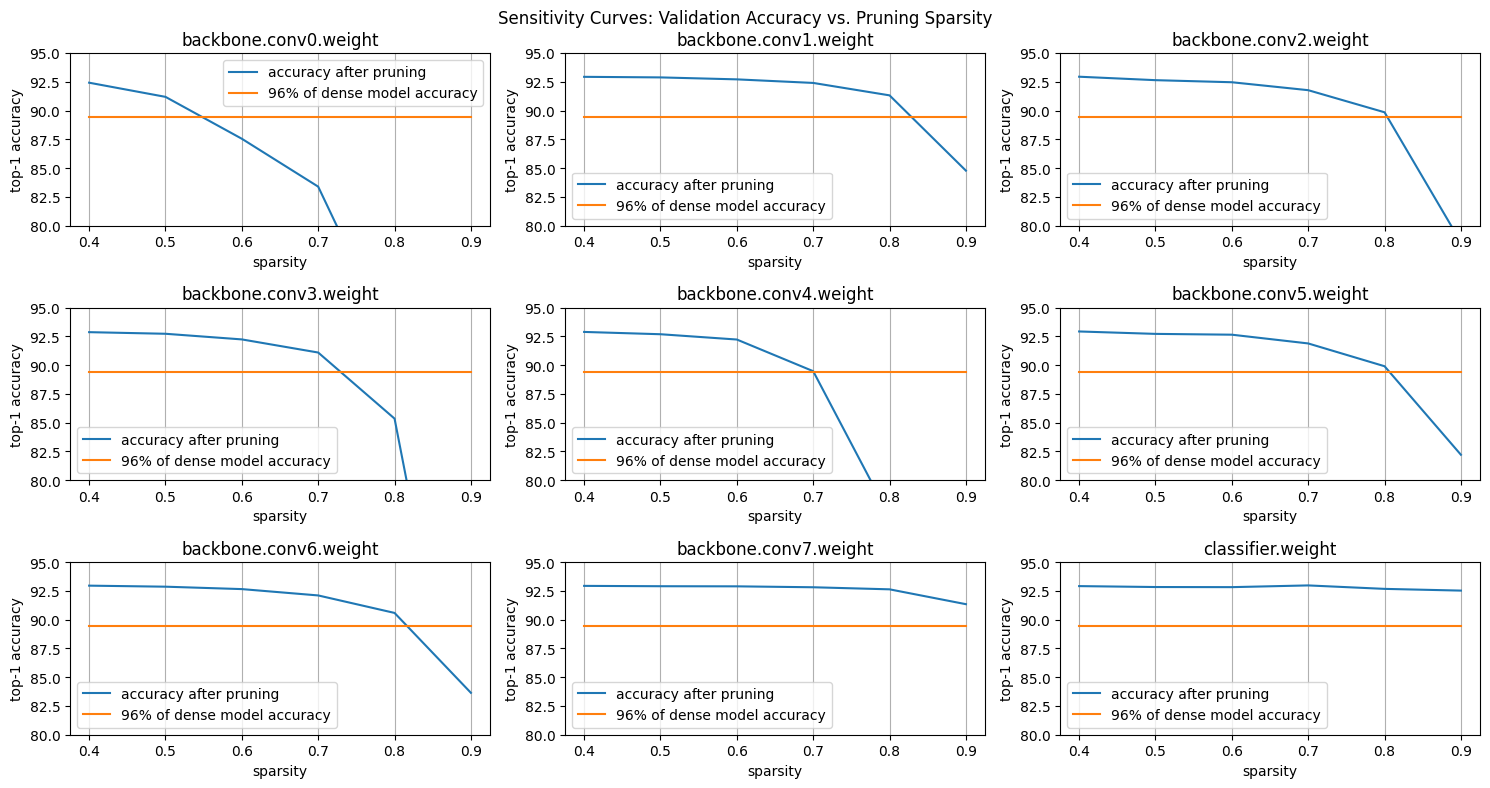

In [19]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

##### 问题4（15分）
请使用上述灵敏度曲线中的信息回答以下问题。

##### 问题4.1（5分）
剪枝稀疏性和模型精度之间的关系是什么？（即，当稀疏性变得更高时，精度是增加还是减少？）

答：稀疏性越高精度减少
* 剪枝通过去除模型中一些权重来提高计算效率和减少内存占用，而高稀疏性意味着去除了更多的权重。

##### 问题4.2（5分）
所有层的灵敏度都一样吗？

答：不一样

##### 问题4.3（5分）
哪一层对修剪稀疏最敏感？

答：backbone.conv0.weight 第一个卷积层

#### 每一层参数
除了精度，每个层的参数数量也会影响稀疏度选择的决策。参数越多的层需要更大的稀疏度。

请运行以下代码单元格来绘制整个模型中参数的分布。

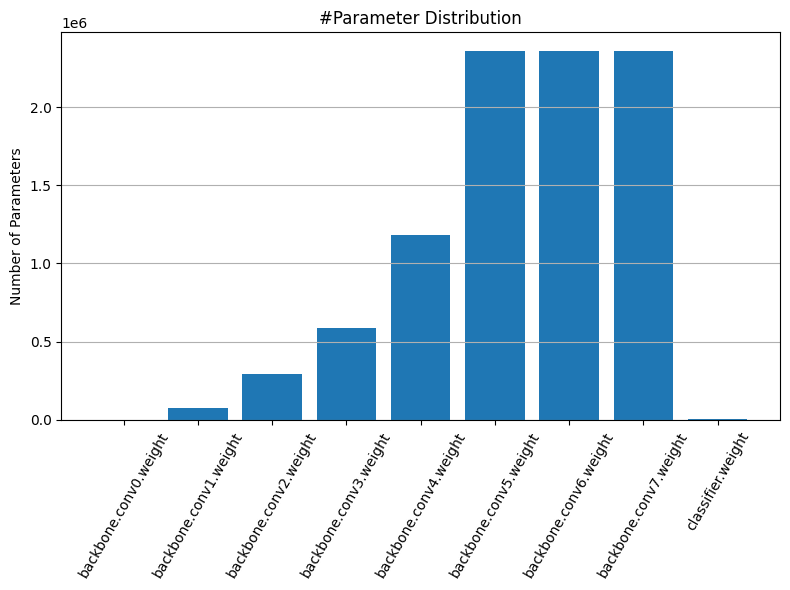

In [20]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

#### 选择稀疏性
根据灵敏度曲线和模型中参数的分布，请选择每一层的稀疏度
##### 问题5（10分）
根据灵敏度曲线和模型中参数的分布，请选择每一层的稀疏度。

请注意，修剪模型的整体压缩比主要取决于#参数较大的层，不同的层对修剪的敏感性不同（见问题4）。

请确保修剪后稀疏模型是密集模型大小的25%，微调后验证精度高于92.5。

提示：
* 具有更多#参数的层应该具有更大的稀疏性。（参见图参数分布）
* 对修剪稀疏性敏感的层（即，随着稀疏性变得更高，精度会迅速下降）应该具有更小的稀疏性。（参见图灵敏度曲线）

In [31]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.3,
    'backbone.conv1.weight': 0.4,
    'backbone.conv2.weight': 0.4,
    'backbone.conv3.weight': 0.5,
    'backbone.conv4.weight': 0.7,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.8,
    'classifier.weight': 0.6
##################### YOUR CODE ENDS HERE #######################
}

请运行以下单元格根据您定义的sparsity_dict修剪模型，并打印稀疏模型的信息。

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.30
  backbone.conv1.weight: 0.40
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.80
  classifier.weight: 0.60
The sparsity of each layer becomes
  backbone.conv0.weight: 0.30
  backbone.conv1.weight: 0.40
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.80
  classifier.weight: 0.60
Sparse model has size=8.75 MiB = 24.86% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=88.09% before fintuning


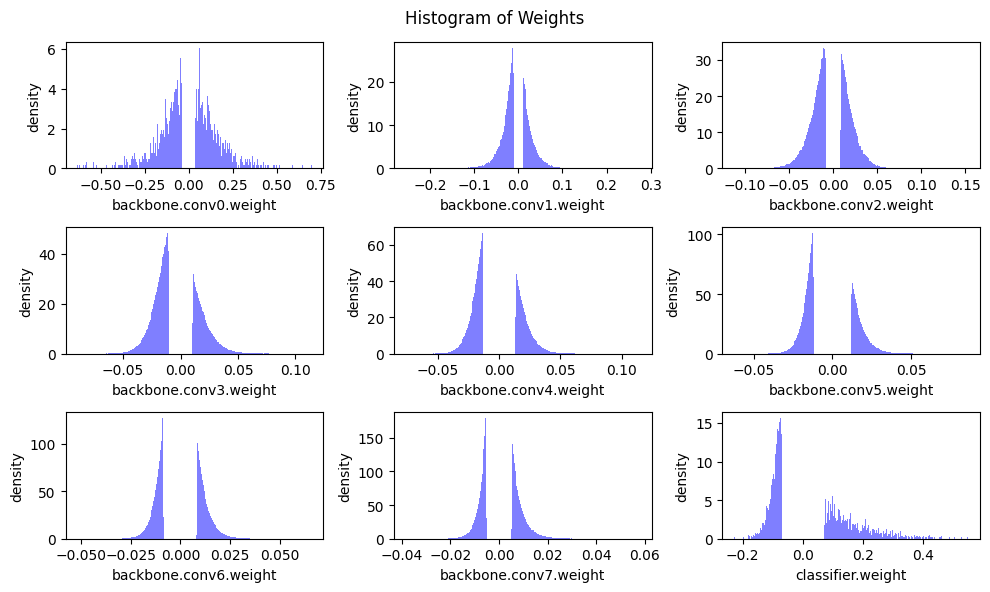

In [32]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

#### 微调细粒度修剪模型
从上一个单元的输出可以看出，尽管细粒度剪枝减少了大部分模型权重，但模型的精度也下降了。因此，我们必须微调稀疏模型来恢复精度。

请运行以下单元格来微调稀疏模型。大约需要3分钟才能完成。

In [33]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.46% / Best Accuracy: 92.46%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.70% / Best Accuracy: 92.70%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.82% / Best Accuracy: 92.82%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.83% / Best Accuracy: 92.83%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.74% / Best Accuracy: 92.83%


运行以下单元格以查看最佳微调稀疏模型的信息。

In [34]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=8.75 MiB = 24.86% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.83% after fintuning


### 通道修剪
在本节中，我们将实现通道剪枝。通道剪枝删除了整个通道，以便在现有硬件（如GPU）上实现推理速度。同样，我们删除了权重较小的通道（由Frobenius范数测量）。

In [35]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


#### 删除通道权重
与细粒度剪枝不同，我们可以在通道剪枝中完全从张量中去除权重。也就是说，减少了输出通道的数量：

`#out_channelsnew=#out_channelsorigin⋅(1−sparsity)`

权重张量 W 通道修剪后仍然密集。因此，我们将参考稀疏性作为修剪率.

像细粒度的剪枝，我们可以对不同的图层使用不同的剪枝率，但是，我们目前对所有图层使用统一的剪枝率，我们的目标是减少2倍的计算量，大致是30%的统一剪枝率（想想为什么）。

请在本节末尾尝试每层不同的修剪比率。您可以将比率列表传递给channel_prune函数。

##### 问题6（10分）
请完成以下通道修剪功能。

在这里，我们天真地修剪除第一个之外的所有输出通道 #out_channels new的 频道。

In [42]:
# 计算在剪枝操作后需要保留的通道数量。通道剪枝的基本思路是根据 prune_ratio(剪枝比例) 来确定从 channels 中保留的数量
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round(channels * (1 - prune_ratio)))
    ##################### YOUR CODE ENDS HERE #####################

# 对模型中的卷积层执行通道剪枝
@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # 检查 prune_ratio 类型并处理
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    # 如果 prune_ratio 是 float，转为列表格式
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # 深拷贝模型以防止覆盖
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)

    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # 修剪上一卷积层的输出和批归一化层
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # 修剪下一卷积层的输入
        # 将当前层的权重张量从计算图中分离出来, 避免在反向传播中计算梯度
        # 表示从权重张量中保留所有输出通道（:），但仅保留前 n_keep 个输入通道
        # 希望保留与上一层输出通道对应的输入通道，以保持模型的连贯性
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


运行以下单元格以执行健全性检查以确保实现正确。

In [43]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


现在让我们以30%的剪枝率评估均匀通道剪枝后模型的性能。

如您所见，直接删除30%的通道会导致准确率低。

In [44]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.15%


#### 按重要性对频道进行排名
如您所见，删除所有层中的前30%通道会导致精度显着降低。解决这个问题的一种潜在方法是找到要删除的不太重要的通道权重。重要性的一个流行标准是使用每个输入通道对应的权重的Frobenius范数：

`importancei=∥Wi∥2,i=0,1,2,⋯,#in_channels−1`

我们可以将渠道权重从更重要到不太重要进行排序，然后保持第一 k 每一层的通道。

##### 问题7（15分）
请完成以下基于Frobenius范数对权重张量进行排序的函数。

提示：
* 为了计算张量的Frobenius范数，Pytorch提供了`torch.norm`API。

In [45]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        # 计算 Frobenius 范数
        importance = torch.norm(channel_weight, p='fro')
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        # 根据之前计算出的通道重要性对下一个卷积层的输入通道进行排序和更新
        # detach() 方法用于返回一个新的张量，该张量与原张量共享数据但不计算梯度
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

现在运行以下单元格以检查结果是否正确。

In [46]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


最后，我们比较了有排序和没有排序的剪枝模型的准确性。

In [47]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.15%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


如您所见，通道排序可以稍微提高修剪模型的准确性，但仍然存在巨大的降级，这对于通道修剪来说很常见。但幸运的是，我们可以执行微调以恢复准确性。

In [48]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.75% / Best Accuracy: 91.75%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 91.90% / Best Accuracy: 91.90%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 91.90% / Best Accuracy: 91.90%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.13% / Best Accuracy: 92.13%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.37% / Best Accuracy: 92.37%


#### 从修剪中测量加速度
微调后，模型几乎恢复了精度。您可能已经了解到，与细粒度修剪相比，通道修剪通常更难恢复精度。然而，它直接导致模型大小更小，计算量更小，无需专门的模型格式。它还可以在GPU上运行得更快。现在我们比较修剪模型的模型大小、计算量和延迟。

In [49]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    8.5             5.5             1.5            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


##### 问题8（10分）
请使用前面代码单元中的信息回答以下问题。

##### 问题8.1（5分）
解释为什么删除30%的通道大致会导致50%的计算量减少。

答：类似排列组合数据减少问题
* 卷积层的计算复杂度与输入和输出通道的数量密切相关。在卷积操作中，输出通道的数量与每个输入通道的加权求和直接相关。当删除30%的通道时，剩余的输出通道仍然需要对输入进行计算，但由于通道的数量减少，每个输出通道的计算量相应减少。因此，计算量的减少效果会更为显著，导致整体计算量减少近50%。

##### 问题8.2（5分）
解释为什么延迟减少率略小于计算减少率。

答：会有其他的操作影响延迟，如索引，指针，寻找非零权重等操作。
* 延迟减少率略小于计算量减少率的原因主要与硬件架构和操作的特性有关。尽管计算量减少了，但模型推理过程中仍然会涉及到其他因素，如数据传输、内存访问和硬件的并行计算能力。这些因素可能会影响延迟的降低。例如，某些硬件在处理较少的操作时，可能由于缓存未命中或其他延迟的增加而无法完全利用计算量的减少。因此，虽然计算量减少明显，延迟的减少程度可能会受到其他限制，从而导致延迟减少率小于计算量减少率。

### 比较细粒度修剪和通道修剪
#### 问题9（10分）
在本实验室的所有实验之后，您可能已经熟悉了细粒度修剪和通道修剪。

请使用您从讲座和本实验室学到的知识回答以下问题。

#### 问题9.1（5分）
细粒度剪枝和通道剪枝的优缺点是什么，可以从压缩比、精度、延迟、硬件支持（即需要专门的硬件加速器）等角度来讨论。

答：<br>
**细粒度：**
* 优点
  * 更灵活，剪枝比例更高，能更好的保持精度
    * 高压缩比：细粒度剪枝可以对单个权重进行裁剪，通过去除个别权重可以达到较高的压缩比，减少存储需求。
    * 精度保持较好：因为只剪除不重要的权重，不改变网络结构，模型的性能损失较小，尤其在剪枝较少时。
* 缺点
  * 很难加速，GPU对不同的线程更愿意以同步的方式进行工作
    * 延迟问题：细粒度剪枝会导致矩阵稀疏性增加，这种稀疏结构在常规硬件上难以高效执行，可能导致延迟增高。
    * 硬件支持：细粒度剪枝生成的稀疏矩阵在通用硬件（如CPU、GPU）上不易加速，需要专门的稀疏矩阵乘法优化的硬件或加速器（如TPU）来支持，增加了对硬件的依赖。

**通道剪枝:**
* 优点
  * 可以直接加速，减少了通道的数量
  * 不需要任何专用的硬件
    * 较低延迟：通道剪枝去掉整个卷积核通道或神经元，生成的模型仍为稠密结构，适合现有硬件（如CPU、GPU）高效运算，减少延迟。
    * 更强的硬件兼容性：稠密的卷积操作能在大多数通用硬件上高效执行，因此无需专门的加速器支持。
* 缺点
  * 较小的压缩比，大约30%参数
    * 压缩比相对较低：通道剪枝的粒度较粗，可能很难实现细粒度剪枝那样高的压缩比。
    * 精度影响较大：因为通道剪枝直接去掉整个卷积核通道或网络中的神经元，可能导致模型性能显著下降，特别是在没有经过进一步优化的情况下。

#### 问题9.2（5分）
如果你想让你的模型在智能手机上运行得更快，你会使用哪种修剪方法？为什么呢？

答：使用通道修剪
* 显著的计算量减少： 通道修剪可以大幅减少计算量和模型大小，这对于资源有限的智能手机尤其重要。
* 实现简单性： 相较于细粒度修剪，通道修剪的实现和维护更为简单，适合快速部署。
* 兼容性： 通道修剪后的模型在许多现代硬件上能较好地运行，且可以利用GPU的并行计算能力。